In [2]:
import json
import os
import pandas as pd

import math


In [3]:
#open file

fileList = os.listdir("data")

#fileList
f = open("data/"+"ESZ06.json")

data = json.load(f)

In [4]:
#Can't read pandas directly, unstrucutred messed of a file
#pdData = pd.read_json("data/"+fileList[0])

In [5]:
type(data.keys())

a = set([1,2,3])

In [6]:
sample = data["data"]
dfKeys = set(sample[0].keys()).difference({"raw"})
#Maybe don't set-ify an ordered collenction
df = pd.DataFrame(sample, columns=list(dfKeys))

In [7]:
df

,lowPrice,openInterest,lastPrice,tradeTime,volume,priceChange,percentChange,highPrice,openPrice
0,"1,425.25",0,"1,428.74",12/15/2006,0,+2.74,+0.19%,"1,432.75","1,426.00"
1,"1,412.00","944,337","1,426.00",12/14/2006,"216,489",+11.75,+0.83%,"1,427.50","1,414.00"
2,"1,410.75","974,110","1,414.25",12/13/2006,"219,370",+1.50,+0.11%,"1,418.50","1,413.00"
3,"1,405.00","1,142,457","1,412.75",12/12/2006,"333,953",-1.75,-0.12%,"1,414.75","1,414.75"
4,"1,409.50","1,222,469","1,414.50",12/11/2006,"294,738",+4.50,+0.32%,"1,417.00","1,409.75"
...,...,...,...,...,...,...,...,...,...
59,"1,321.00","1,346,924","1,326.00",09/22/2006,"892,984",-4.25,-0.32%,"1,331.50","1,330.00"
60,"1,325.50","1,352,953","1,330.25",09/21/2006,"1,248,340",-6.25,-0.47%,"1,340.00","1,336.50"
61,"1,329.50","1,324,711","1,336.50",09/20/2006,"970,246",+6.00,+0.45%,"1,339.75","1,330.75"
62,"1,322.75","1,303,729","1,330.50",09/19/2006,"1,176,450",-3.75,-0.28%,"1,334.50","1,333.75"


In [8]:
#Lazy conversion on my end, could've used locales
#str -> specify non total item replacement
df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

In [9]:
df.dtypes

lowPrice                 object
openInterest             object
lastPrice               float64
tradeTime        datetime64[ns]
volume                   object
priceChange              object
percentChange            object
highPrice                object
openPrice                object
dtype: object

In [10]:
import seaborn

In [11]:
#sample = [(x["tradeTime"],x["lastPrice"]) for x in data["data"]]

Text(0, 0.5, 'Last Price')

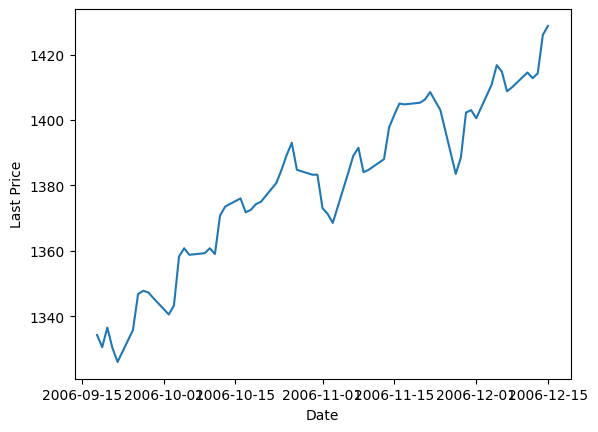

In [12]:
ss = seaborn.lineplot(x="tradeTime", y="lastPrice", data=df)
ss.set_xlabel("Date")
ss.set_ylabel("Last Price")

In [13]:
max(df["tradeTime"])-min(df["tradeTime"])

Timedelta('88 days 00:00:00')

In [14]:
logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept

In [15]:
#Add to 
df["logReturns"] = logRets
#Indexes are kept throughout series!
df = df.drop(0) #drop the first entry for simplicity

<Axes: xlabel='tradeTime', ylabel='logReturns'>

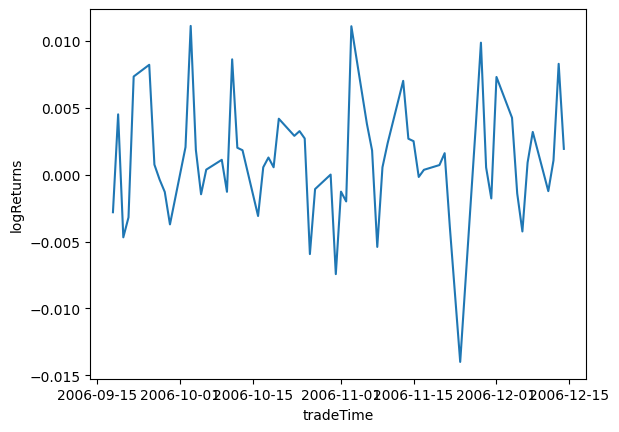

In [16]:
seaborn.lineplot(x="tradeTime", y="logReturns", data=df)

(array([ 1.,  0.,  1.,  4.,  8., 19., 16.,  5.,  5.,  4.]),
 array([-0.01399628, -0.01148615, -0.00897601, -0.00646588, -0.00395575,
        -0.00144561,  0.00106452,  0.00357465,  0.00608479,  0.00859492,
         0.01110506]),
 <BarContainer object of 10 artists>)

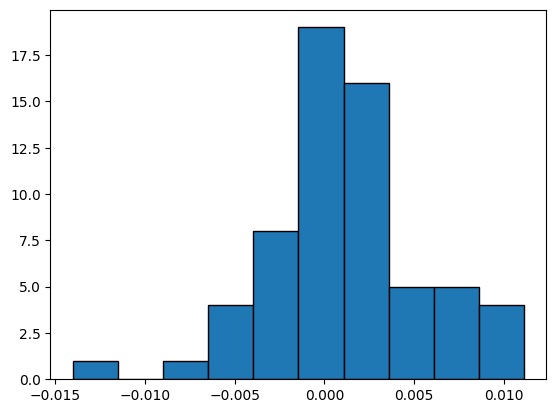

In [17]:
import matplotlib.pyplot as plt
plt.hist(df["logReturns"], edgecolor='black')

In [18]:
import statsmodels.api as sm

In [19]:
#Setup dist
import scipy.stats

#Assuming daily returns, ignoring weekends and bank holidays
bmStdDev = df["logReturns"].std()
bMotion = scipy.stats.norm(loc=0, scale=bmStdDev)

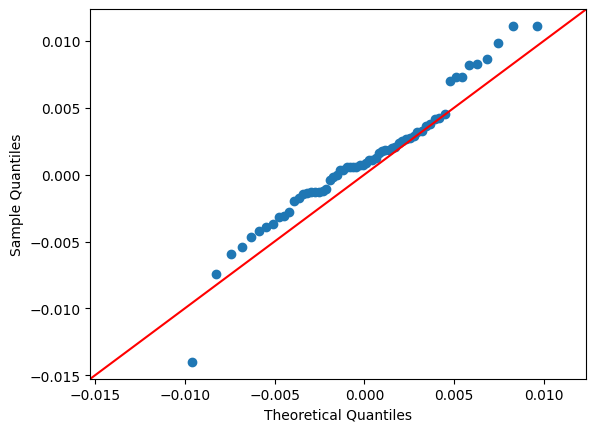

In [20]:
fig = sm.qqplot(df["logReturns"][1:], dist=bMotion, line='45')

In [21]:
#Null Hyp: The underlying dist is normal
scipy.stats.shapiro(df["logReturns"])

ShapiroResult(statistic=0.9636398279262726, pvalue=0.05969879589227293)

In [22]:
df["logReturns"][1:]

2     0.008274
3     0.001061
4    -0.001238
5     0.003186
6     0.000887
        ...   
59    0.007326
60   -0.003200
61   -0.004687
62    0.004499
63   -0.002815
Name: logReturns, Length: 62, dtype: float64

In [80]:
def getReturnsDF(str):
    with open("data/"+str) as f:
        data = json.load(f)

    sample = data["data"]
    dfKeys = set(sample[0].keys()).difference({"raw"})
    #Maybe don't set-ify an ordered collenction
    df = pd.DataFrame(sample, columns=list(dfKeys))

    df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
    df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

    logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept
    df["logReturns"] = logRets
    #Indexes are kept throughout series!
    df = df.drop(0) #drop the first entry for simplicity
    return df

In [23]:
def logRet_shapiroTest(str):

    df = getReturnsDF(str)

    bmStdDev = df["logReturns"].std()
    bMotion = scipy.stats.norm(loc=0, scale=bmStdDev)

    #Null Hyp: The underlying dist is normal
    return scipy.stats.shapiro(df["logReturns"]).pvalue


In [24]:
logRet_shapiroTest(fileList[0])

0.42849579415746947

In [25]:
fileList[0]

'ESH00.json'

In [66]:
testResults = [(x, logRet_shapiroTest(x)) for x in os.listdir("data")]

In [27]:
import re

In [67]:
testResults.sort(key = lambda xs: re.sub("^([a-zA-Z]+)([0-9]+)", "\\2\\1", xs[0])) #Python's RE's are annoyingly close to vims

In [69]:
#Manual resize, could probably use filters or index searches
testResults = testResults[91:] + testResults[:91] 

In [64]:
testResults

[('ESH98.json', 0.05394624284961656),
 ('ESM98.json', 0.6343225221269637),
 ('ESU98.json', 0.00019297326576959308),
 ('ESZ98.json', 0.07166894123614473),
 ('ESH99.json', 0.9433836837312121),
 ('ESM99.json', 0.9806963771039585),
 ('ESU99.json', 0.4340248156125024),
 ('ESZ99.json', 0.6140790662824502),
 ('ESH00.json', 0.42849579415746947),
 ('ESM00.json', 0.0063358213883641665),
 ('ESU00.json', 0.5259736240549313),
 ('ESZ00.json', 0.010471633567879782),
 ('ESH01.json', 0.15290983530385394),
 ('ESM01.json', 0.7729622826916323),
 ('ESU01.json', 0.0042875978082339),
 ('ESZ01.json', 0.16358181158370394),
 ('ESH02.json', 0.2132069608861651),
 ('ESM02.json', 0.25344551346195565),
 ('ESU02.json', 0.281098265148784),
 ('ESZ02.json', 0.29407277927188313),
 ('ESH03.json', 0.2889709753969352),
 ('ESM03.json', 0.3572402298741022),
 ('ESU03.json', 0.9121604968072285),
 ('ESZ03.json', 0.47461146529060866),
 ('ESH04.json', 0.23235897336807054),
 ('ESM04.json', 0.2479168981984718),
 ('ESU04.json', 0.105

In [70]:
infractors = [x for (x,p) in testResults if p < 0.1]
len(infractors)

41

In [32]:
infractors

['ESM00.json',
 'ESZ00.json',
 'ESU01.json',
 'ESZ06.json',
 'ESH07.json',
 'ESM07.json',
 'ESH08.json',
 'ESM08.json',
 'ESU09.json',
 'ESH10.json',
 'ESM10.json',
 'ESZ10.json',
 'ESH11.json',
 'ESU11.json',
 'ESH12.json',
 'ESU12.json',
 'ESH13.json',
 'ESM13.json',
 'ESU13.json',
 'ESH14.json',
 'ESM14.json',
 'ESU14.json',
 'ESU15.json',
 'ESU16.json',
 'ESZ16.json',
 'ESM17.json',
 'ESU17.json',
 'ESH18.json',
 'ESM18.json',
 'ESH19.json',
 'ESM19.json',
 'ESU19.json',
 'ESZ19.json',
 'ESH20.json',
 'ESM20.json',
 'ESU20.json',
 'ESZ20.json',
 'ESU22.json',
 'ESH98.json',
 'ESU98.json',
 'ESZ98.json']

In [77]:
re.sub(".json","",r"a.json")

'a'

<Axes: xlabel='0', ylabel='1'>

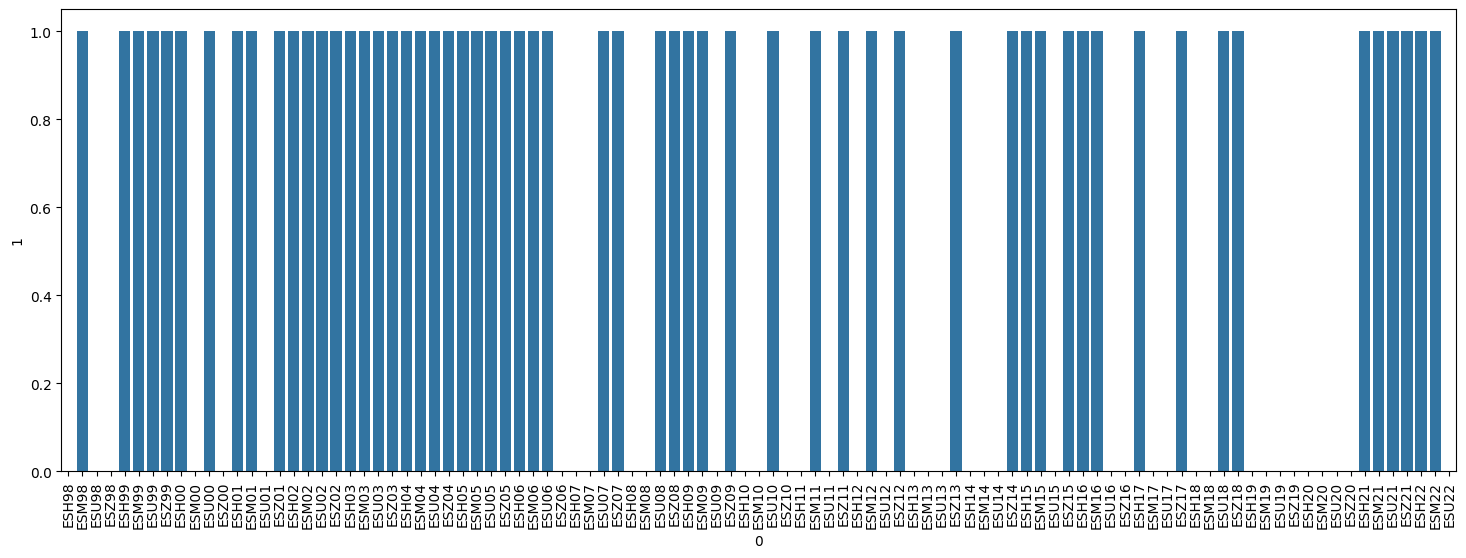

In [78]:
passes = pd.DataFrame([(re.sub(".json", "",x) ,1*(p>0.1)) for (x,p) in testResults], columns=["0","1"])

fig, ax = plt.subplots(figsize=(18, 6))
ax.tick_params(axis='x', labelrotation=90)
seaborn.barplot(x="0", y="1", data=passes)


In [79]:
fig.savefig("../norm.eps",  bbox_inches="tight")

In [81]:
#Get Means
#Should I have cached the DFs? I'm not used to using notebooks
#already sorted in test results

retMeans = [(x, getReturnsDF(x)["logReturns"].mean()) for (x,_) in testResults]

#Wait I don't think he assumed anything for returns...



<Axes: xlabel='0', ylabel='Média retorno diário'>

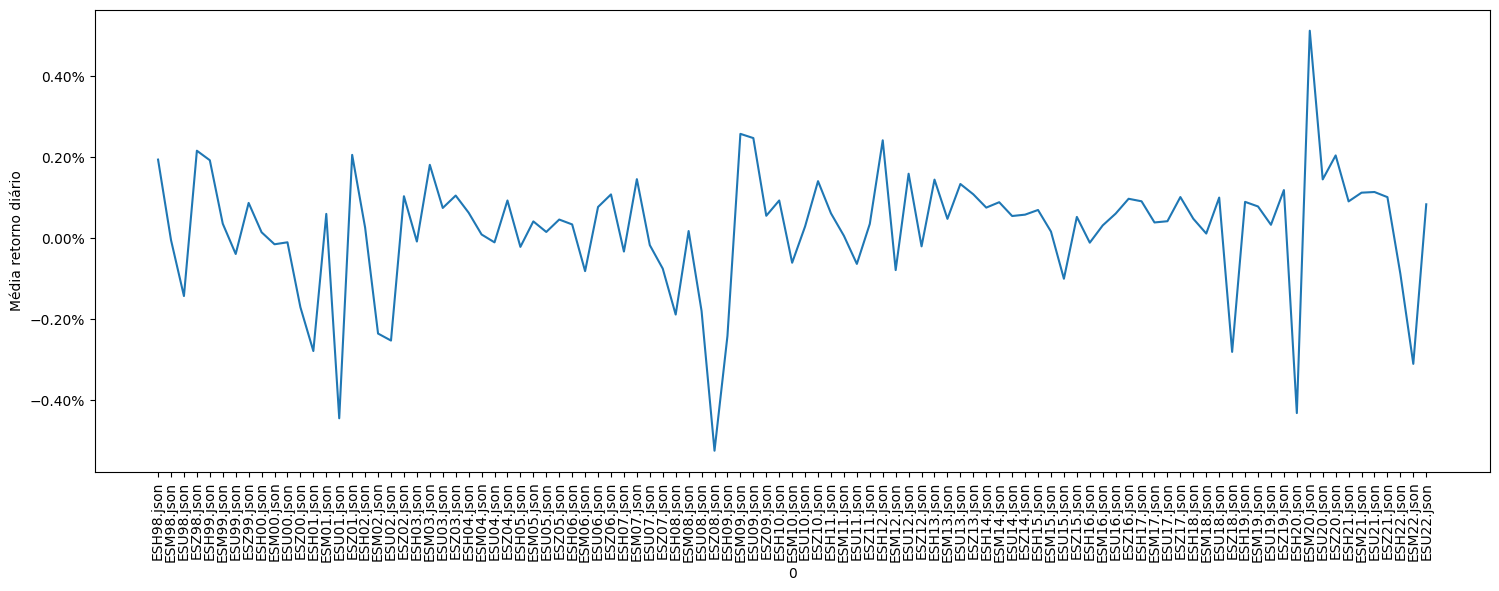

In [94]:
import matplotlib.ticker as mtick
fmt = '{x:.2%}'


fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Média retorno diário")
seaborn.lineplot(x=0, y=1, data=pd.DataFrame(retMeans))



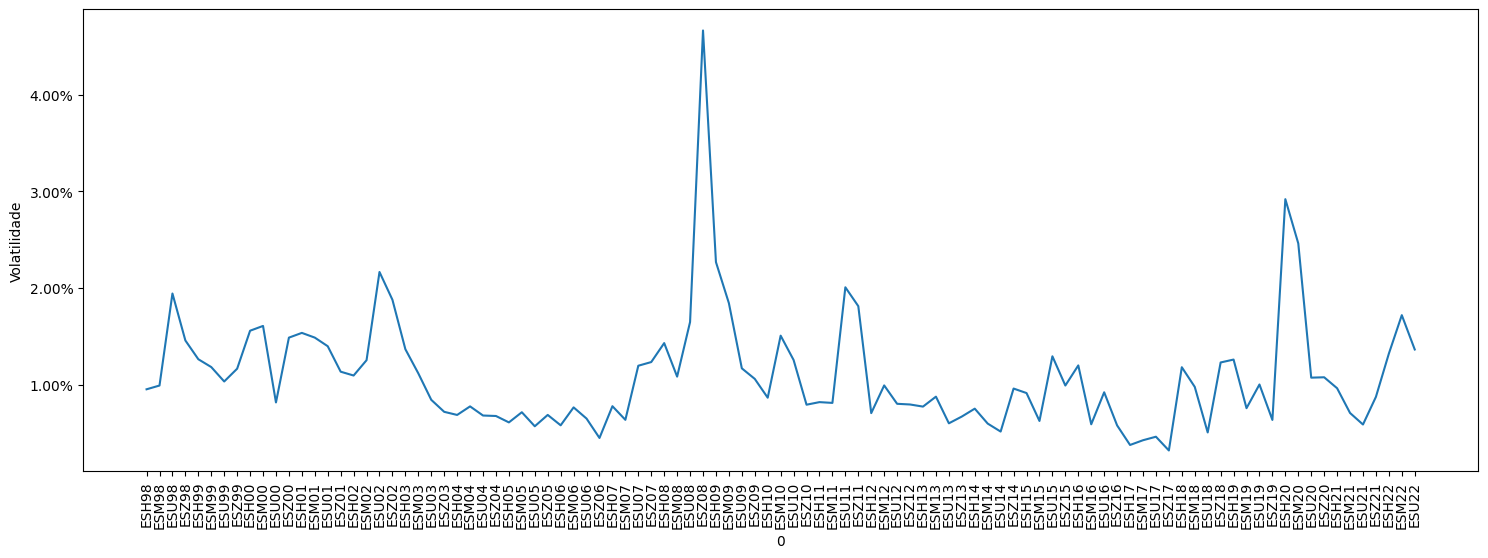

In [98]:
fig, ax = plt.subplots(figsize=(18, 6))
fig.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Volatilidade")
seaborn.lineplot(x=0, y=1, data=pd.DataFrame(
    [(re.sub(".json","",x), getReturnsDF(x)["logReturns"].std()) for (x,_) in testResults]
        )
                )

fig.savefig("../volatility.eps")